In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [252]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime
import xgboost as xgb
from catboost import CatBoostRegressor

In [251]:
!pip install catboost

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Loading datasets 

In [9]:
TRAIN_DATASET_PATH = 'real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = 'real-estate-price-prediction-moscow/test.csv'

In [318]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [157]:
train_df.shape[1] - 1 == test_df.shape[1]

True

# Target feature distribution and correlations

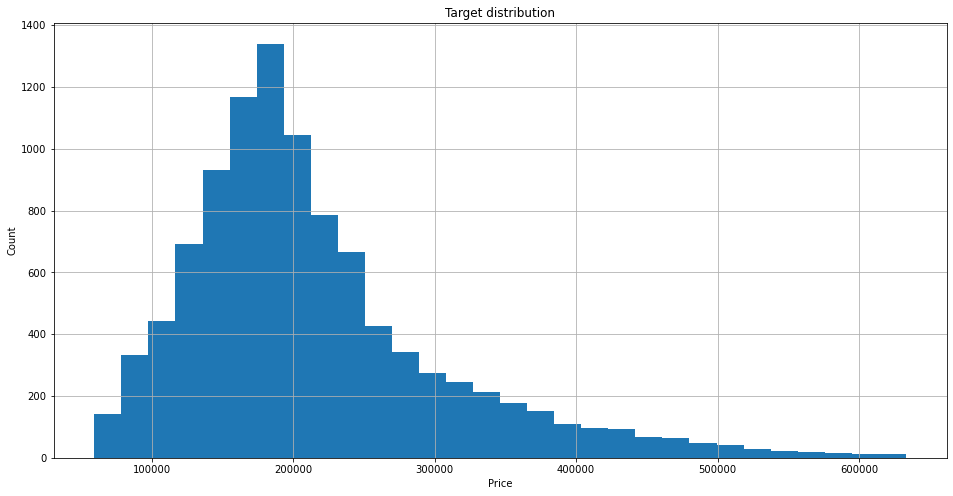

In [12]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

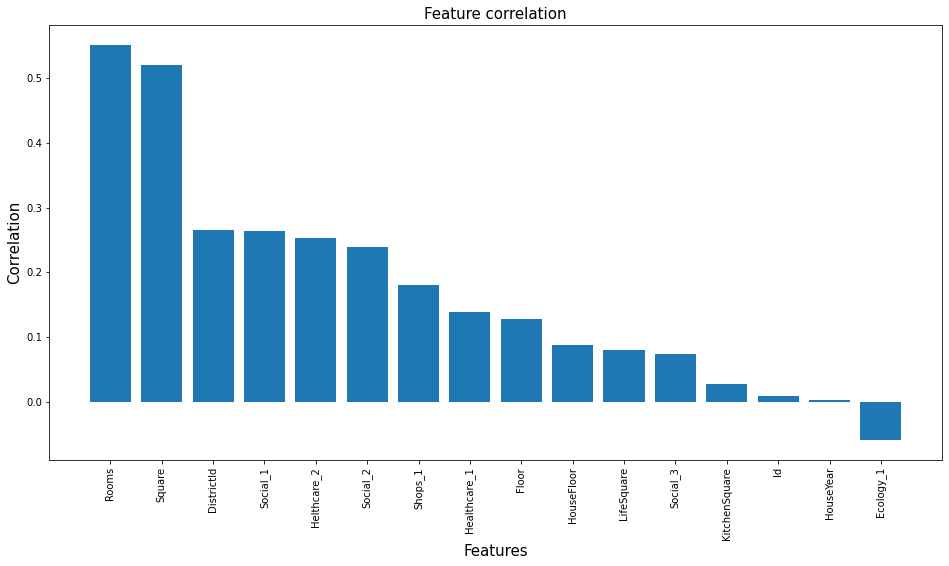

In [13]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

# Data processing and generation of features

In [152]:
class DataPreprocessor:
    def __init__(self):
        self.medians = None
        self.kitchen_square_max_value = None
        self.kitchen_square_min_value = None
        self.life_square_min_value = None
        self.max_floor = None
        self.districts_healthcare = None


        
    def fit(self, df):
        # Medians and quantiles
        self.medians = df.median() # medians
        self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.999) 
        self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.001) 
        self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03) 
        self.max_floor = df['Floor'].max()
        
        
        # Compute mean Helthcare_1 value in each district
        self.districts_healthcare = df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, df):
        # Life Square fillna
        df['LifeSquare'].fillna(((df['Square'] - df['KitchenSquare']) - df['Square']*0.2), inplace=True)


        # Rooms
        # Fillna with medians         
        df['Rooms'].fillna(self.medians.Rooms, inplace=True) 
        
        # Compute median room square and fill outliers with LifeSquare/Room_square 
        condition_rooms = (df['Rooms'] > 6) | (df['Rooms'] == 0)   
        room_sq = np.round((self.medians.LifeSquare / self.medians.Rooms, 1))[0]
        df.loc[condition_rooms , 'Rooms'] = df.loc[condition_rooms, 'LifeSquare'] / room_sq

        # Square
        # If LifeSquare > Square: exchange values
        df['Square'], df['LifeSquare'] = np.where(df['Square'] < df['LifeSquare'],(df['LifeSquare'],df['Square']), (df['Square'],df['LifeSquare']))


        # LifeSquare
        # Fill outliers with (Square - KithcenSquare)
        ls_condition = (df['LifeSquare'] < self.life_square_min_value)
        df.loc[ls_condition, 'LifeSquare'] = df.loc[ls_condition, ['Square']] - df.loc[ls_condition, ['KitchenSquare']]
  
        
        # KitchenSquare
        # Fill outliers with (Square - LifeSquare - 10% of Square)
        condition_kitchen_square = (df['KitchenSquare'] > self.kitchen_square_max_value) | (df['KitchenSquare'] < self.kitchen_square_min_value)
        df.loc[condition_kitchen_square, 'KitchenSquare'] = df.loc[condition_kitchen_square, 'Square'] - df.loc[condition_kitchen_square, 'LifeSquare'] \
        - (df.loc[condition_kitchen_square, 'Square'] * 0.1)


        # Ecology and Shops
        # Switch to binary
        df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        
        # HouseFloor
        # If HouseFloor < Floor: exchange values
        house_floor_condition = df['HouseFloor'] < df['Floor']
        df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']
        
        df.loc[((df['HouseFloor']>25) | (df['HouseFloor']<1)), 'HouseFloor'] = df['HouseFloor'].mean()
        df.loc[((df['Floor']>25) | (df['Floor']<1)), 'Floor'] = df['Floor'].mean()

        
        # HouseYear
        # If HouseYear > current year set median value
        current_year = datetime.now().year
        condition_year = (df['HouseYear'] > current_year)
        df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        
        
        # Healthcare
        # Fillna with dictrict healthcare value. (If district has no healthcare value fill with medians)      
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1'] = df['DistrictId'].map(self.districts_healthcare)
        df['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Clip on upper quantille
        q_max = np.quantile(df['Healthcare_1'], q=0.9)
        df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
        
        
        # Drop Id
        df.drop(['Id'], axis=1, inplace=True)

        
        # Fillna just in case
        df.fillna(self.medians, inplace=True)
        return df




In [319]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None
        self.districts_density = None
        self.district_price_per_square = None
        self.min_sq = None
        self.max_sq = None

        
    def fit(self, df):   
        self.min_sq = np.quantile(df['Square'], q=0.005)
        self.max_sq = np.quantile(df['Square'], q=0.995)
        
        self.districts_median_year = df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()  # median house year in each district
        self.districts_density = df.groupby(['DistrictId'])['Square'].agg('median').to_dict()  # median square in each district
        self.district_price_per_square = df.groupby(['DistrictId'])['Price'].agg('median') \
        / df.groupby(['DistrictId'])['Square'].agg('median')  # median price for square meter in each district
        
    
    def new_features(self, df):
        # How old is the district      
        df['DistrictYear'] = df['DistrictId'].map(self.districts_median_year)
        
        self.median_district_year = df['DistrictYear'].median()
        df['DistrictYear'].fillna(self.median_district_year, inplace=True)


        # Median square of flat in each district
        df['DistrictDensity'] = df['DistrictId'].map(self.districts_density)
        
        self.median_district_density = df['DistrictDensity'].median()
        df['DistrictDensity'].fillna(self.median_district_density, inplace=True)


        # Median price for square meter in each district
        self.district_price_per_square.to_dict()
        df['DistrictPrice'] = df['DistrictId'].map(self.district_price_per_square)
        
        self.median_district_price_per_square = df['DistrictPrice'].median()
        df['DistrictPrice'].fillna(self.median_district_price_per_square, inplace=True)


        # Floor category
        '''floor_bins = [0, 4, 7, 12, df['Floor'].max()]
        df['Floor_cat'] = pd.cut(df['Floor'], bins=floor_bins, labels=False)
        df['Floor_cat'].fillna(-1, inplace=True) '''
        

        
        # Scale and merge Social
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(df[['Social_1', 'Social_2']]))#, 'Social_3'
        df['Social'] = pca.fit_transform(social_scaled)
        
        
        df.drop(['Ecology_2', 'Ecology_3', 'Helthcare_2', 'Shops_2'], axis=1, inplace=True)#'Shops_2' 'Floor',
        
        return df
    
    
    def drop_outliers(self, df):
        df = df.loc[(df['Square'] > self.min_sq) & (df['Square'] < self.max_sq)]
        
        
        
        return df


Data preprocessing

In [320]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

Feature generation

In [321]:
features_gen = FeatureGenerator()
features_gen.fit(train_df)
train_df = features_gen.new_features(train_df)
train_df = features_gen.drop_outliers(train_df)
test_df = features_gen.new_features(test_df)

Modyfying

In [322]:

train_df['DistrictCost']=train_df['DistrictId'].map(train_df.groupby(['DistrictId'])['Price'].agg('median'))

train_df[['CheapDistrict', 'ExpensiveDistrict']] = 0
train_df.loc[(train_df['DistrictCost'] > 300000), 'ExpensiveDistrict'] = 1
train_df.loc[(train_df['DistrictCost'] < 300000), 'CheapDistrict'] = 1

train_df.drop('DistrictCost', axis=1, inplace=True)

test_df=test_df.copy()
test_df[['CheapDistrict', 'ExpensiveDistrict']] = 0
exp_dist = train_df.loc[(train_df['ExpensiveDistrict'] == 1), 'DistrictId'].unique()
for x in exp_dist:
    test_df.loc[(test_df['DistrictId'] == x), 'ExpensiveDistrict'] = 1
test_df.loc[(test_df['ExpensiveDistrict'] == 1), 'CheapDistrict'] = 1

In [323]:
train_df['HouseFloor'] = train_df['HouseFloor'].astype(str)
price_per_floors = train_df.groupby(['HouseFloor'])['Price'].agg('median').to_dict()
train_df['FloorsPrice'] = train_df['HouseFloor'].map(price_per_floors)
test_df['FloorsPrice'] = test_df['HouseFloor'].map(price_per_floors)

In [324]:
train_df['HouseFloor'] = train_df['HouseFloor'].astype('str')
test_df['HouseFloor'] = test_df['HouseFloor'].astype('str')
test_df['FloorsPrice'] = test_df['HouseFloor'].map(price_per_floors)
train_df['HouseFloor'] = train_df['HouseFloor'].astype('float')
test_df['HouseFloor'] = test_df['HouseFloor'].astype('float')
test_df['FloorsPrice'].fillna(test_df['FloorsPrice'].mean(), inplace=True)

In [346]:

train_df.drop(['Floor_cat'], axis=1, inplace=True)
test_df.drop(['Floor_cat'], axis=1, inplace=True)

Dataset split

In [347]:
#y = pd.DataFrame(data=train_df['Price'])
#train_df.drop('Price', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.15, random_state=100)


Gradient Boosting Regressor model fit and predict for train dataset

In [327]:
gb_model = GradientBoostingRegressor(criterion='friedman_mse',
                                     max_depth=6,
                                     min_samples_leaf=100,
                                     random_state=42,  
                                     n_estimators=4500,#2250, 
                                     max_features='log2',#'sqrt', 
                                     loss='huber', 
                                     learning_rate=0.015)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.8490290536074898
0.8001914660704705


XGBR model model fit and predict for train dataset

In [348]:
gb_model2 = xgb.XGBRegressor(colsample_bytree=0.4445, 
                             learning_rate=0.005, max_depth=6,
                             min_child_weight=0.1, 
                             n_estimators=2500,
                             reg_lambda=0.6,
                             random_state =7)
gb_model2.fit(X_train, y_train)

y_train_preds = gb_model2.predict(X_train)
y_test_preds = gb_model2.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.9061552237812935
0.7897137566278453


In [349]:
final_model = CatBoostRegressor(
    learning_rate=0.005,
    depth=9,
    l2_leaf_reg=2,
    iterations=3500,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=21,
    silent=True,
)
'''CatBoostRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8)'''
final_model.fit(X_train, y_train)

y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)
print(r2(y_train, y_train_preds))
print(r2(y_test, y_test_preds))

0.9084628550985301
0.7966382763116122


Feature importance

In [344]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
2,Square,27.088418
16,DistrictPrice,18.535751
7,HouseYear,6.453319
4,KitchenSquare,4.903472
1,Rooms,3.452087
8,Ecology_1,3.346287
11,Social_3,3.252164
20,FloorsPrice,3.181549
3,LifeSquare,3.119902
14,DistrictYear,2.974329


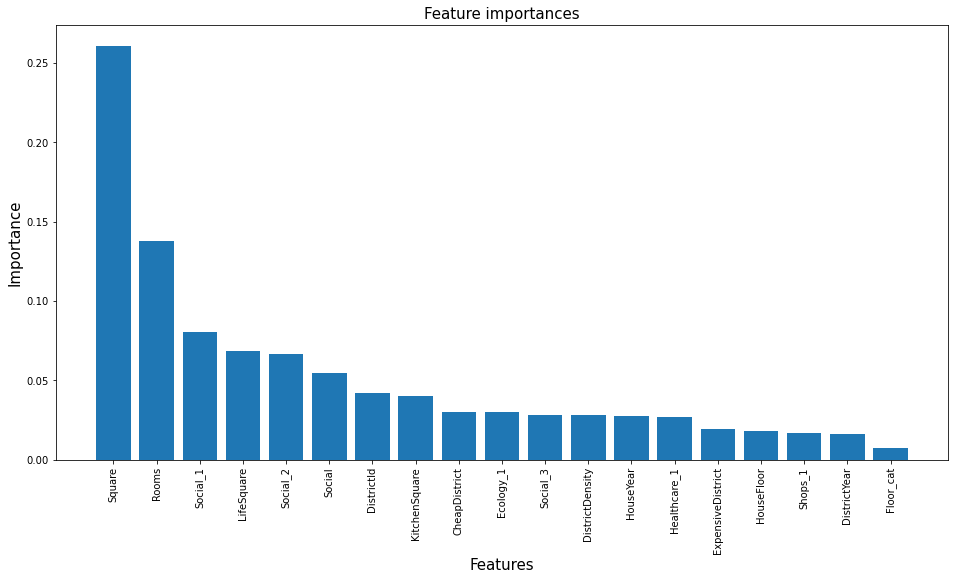

In [121]:
plt.figure(figsize = (16, 8))
plt.bar(feature_importances['feature_name'], feature_importances['importance'])
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature importances', fontsize=15)
plt.show()

Test data set prediction and submition to kaggle

In [224]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DistrictId         5000 non-null   int64  
 1   Rooms              5000 non-null   float64
 2   Square             5000 non-null   float64
 3   LifeSquare         5000 non-null   float64
 4   KitchenSquare      5000 non-null   float64
 5   Floor              5000 non-null   float64
 6   HouseFloor         5000 non-null   float64
 7   HouseYear          5000 non-null   int64  
 8   Ecology_1          5000 non-null   float64
 9   Social_1           5000 non-null   int64  
 10  Social_2           5000 non-null   int64  
 11  Social_3           5000 non-null   int64  
 12  Healthcare_1       5000 non-null   float64
 13  Shops_1            5000 non-null   int64  
 14  Shops_2            5000 non-null   int64  
 15  DistrictYear       5000 non-null   float64
 16  DistrictDensity    5000 

In [196]:
X_train.head(2)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Shops_1,Shops_2,DistrictYear,DistrictDensity,DistrictPrice,Social,CheapDistrict,ExpensiveDistrict,FloorsPrice
8785,134,2.0,39.697957,25.214448,7.0,5.0,9.0,1969,0.015017,17,...,2300.0,8,1,1977.0,42.382091,6161.829301,-0.472905,1,0,196314.695239
9074,8,1.0,39.195153,22.158768,9.0,12.0,12.0,1968,0.437885,23,...,1084.0,5,1,1983.0,47.651571,3975.516530,0.016679,1,0,197485.146810
8209,71,1.0,42.338652,20.734897,8.0,8.0,12.0,2001,0.033494,66,...,1322.0,8,1,1984.0,43.604753,3946.969493,1.585751,1,0,197485.146810
2018,30,3.0,83.770957,66.016766,1.0,12.0,12.0,2017,0.000078,22,...,1046.0,23,1,1977.0,61.159895,2685.732205,0.086144,1,0,197485.146810
9408,26,3.0,64.626681,46.929294,9.0,7.0,12.0,1967,0.000000,36,...,2300.0,2,1,1976.0,47.405424,4403.133589,0.424971,1,0,197485.146810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,27,2.0,62.015976,48.612781,1.0,11.0,17.0,1977,0.011654,4,...,900.0,0,1,1977.0,55.064041,2654.571480,-1.043097,1,0,183324.685049
79,99,2.0,47.304766,28.737215,6.0,9.0,9.0,1972,0.012339,35,...,2078.0,4,1,1973.0,45.363892,3942.103724,0.275699,1,0,196314.695239
8120,52,1.0,40.798472,38.683422,1.0,8.0,17.0,2018,0.371149,34,...,750.0,5,1,1977.0,55.084501,2994.023919,0.430690,1,0,183324.685049
7004,1,2.0,56.209735,30.719953,8.0,15.0,15.0,1991,0.025609,33,...,240.0,1,1,1977.0,60.631137,3029.193475,0.163101,1,0,195454.651452


In [225]:
submit = pd.read_csv('real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [339]:
predictions = gb_model.predict(test_df)
predictions

array([166438.66902458, 132003.31834751, 143609.89344616, ...,
       150281.2600022 , 190144.20450764, 298523.77893495])

In [350]:
predictions2 = gb_model2.predict(test_df)
predictions2

array([172982.28, 137568.56, 152154.62, ..., 148658.64, 190718.34,
       276764.03], dtype=float32)

In [351]:
predictions3 = final_model.predict(test_df)
predictions3

array([166826.36305156, 135314.22180121, 154307.7862943 , ...,
       148187.97337404, 189800.41907899, 270220.15730401])

In [357]:
submit['Price'] = predictions3
submit.head()

,Id,Price
0,4567,166826.363052
1,5925,135314.221801
2,960,154307.786294
3,3848,112809.600933
4,746,175812.857501


In [63]:
submit.shape

(5000, 2)

In [232]:
predictions2.shape

(5000,)

In [358]:
submit.to_csv('gb_submit_catboost.csv', index=False)

In [352]:
preds = np.stack([predictions2, predictions3])#, predictions2
preds.shape

(2, 5000)

In [356]:
predictions_fin = preds.avg(axis=0)
predictions_fin.shape

AttributeError: 'numpy.ndarray' object has no attribute 'avg'

In [354]:
submit['Price'] = predictions_fin
submit.head()

,Id,Price
0,4567,169904.322151
1,5925,136441.392151
2,960,153231.205647
3,3848,113719.183279
4,746,178884.616251


In [355]:
submit.to_csv('gb_submit_23mixed.csv', index=False)